In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# 1. Define paths (Adjust these based on the exact Kaggle dataset structure)
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

# Merge image paths from both folders into a dictionary for quick lookup
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# 2. Load the metadata
df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# 3. Create a new column 'path' by mapping the image_id to the actual file path
df['path'] = df['image_id'].map(imageid_path_dict)

# 4. Map the short 'cell_type' codes to full readable names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict)

print(f"Total images found: {len(df)}")
df.head()

Total images found: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions


/tmp/ipykernel_55/159609353.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['cell_type'], order = df['cell_type'].value_counts().index, palette='viridis')


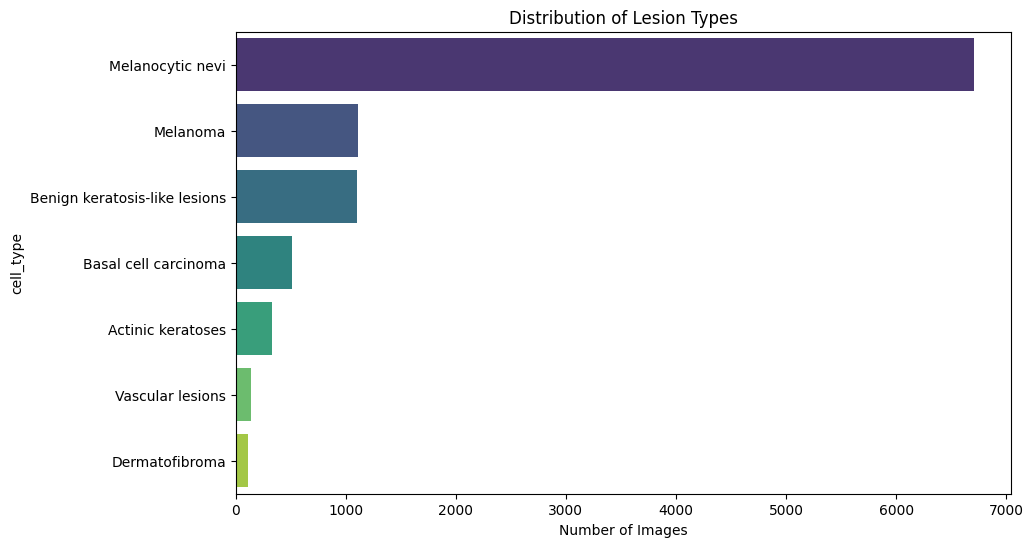

In [3]:
plt.figure(figsize=(10,6))
sns.countplot(y=df['cell_type'], order = df['cell_type'].value_counts().index, palette='viridis')
plt.title('Distribution of Lesion Types')
plt.xlabel('Number of Images')
plt.show()

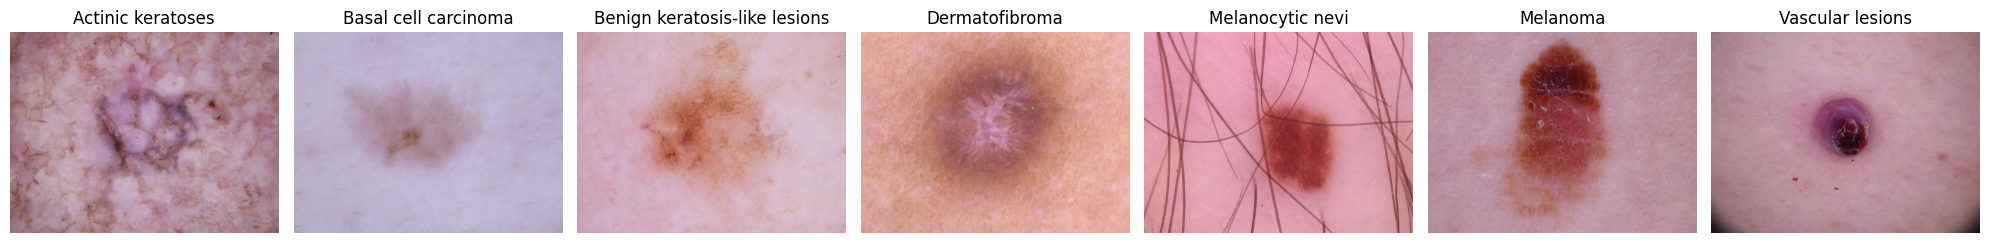

In [4]:
# Display a sample of each disease type
fig, ax1 = plt.subplots(1, 7, figsize=(20, 10))
for i, (type_name, group) in enumerate(df.groupby('cell_type')):
    sample = group.sample(1)
    img_path = sample['path'].values[0]
    img = plt.imread(img_path)
    ax1[i].imshow(img)
    ax1[i].set_title(type_name)
    ax1[i].axis('off')
plt.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split

# First split: Train + Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df['dx']
)

# Second split: Validation + Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['dx']
)

print("Train distribution:")
print(train_df['cell_type'].value_counts())

print("\nValidation distribution:")
print(val_df['cell_type'].value_counts())

print("\nTest distribution:")
print(test_df['cell_type'].value_counts())


Train distribution:
cell_type
Melanocytic nevi                 4693
Melanoma                          779
Benign keratosis-like lesions     769
Basal cell carcinoma              360
Actinic keratoses                 229
Vascular lesions                   99
Dermatofibroma                     81
Name: count, dtype: int64

Validation distribution:
cell_type
Melanocytic nevi                 1006
Melanoma                          167
Benign keratosis-like lesions     165
Basal cell carcinoma               77
Actinic keratoses                  49
Vascular lesions                   21
Dermatofibroma                     17
Name: count, dtype: int64

Test distribution:
cell_type
Melanocytic nevi                 1006
Melanoma                          167
Benign keratosis-like lesions     165
Basal cell carcinoma               77
Actinic keratoses                  49
Vascular lesions                   22
Dermatofibroma                     17
Name: count, dtype: int64


In [8]:
from sklearn.utils import resample

max_size = train_df['dx'].value_counts().max()

balanced_train = []
for label, group in train_df.groupby('dx'):
    balanced_train.append(
        resample(
            group,
            replace=True,
            n_samples=max_size,
            random_state=42
        )
    )

train_df_balanced = pd.concat(balanced_train).sample(frac=1, random_state=42)

print("\nBalanced Training Set:")
print(train_df_balanced['cell_type'].value_counts())



Balanced Training Set:
cell_type
Basal cell carcinoma             4693
Melanocytic nevi                 4693
Benign keratosis-like lesions    4693
Dermatofibroma                   4693
Actinic keratoses                4693
Vascular lesions                 4693
Melanoma                         4693
Name: count, dtype: int64


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation & Test: NO augmentation
eval_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 32851 validated image filenames belonging to 7 classes.


In [11]:
val_generator = eval_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1502 validated image filenames belonging to 7 classes.


In [12]:
test_generator = eval_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1503 validated image filenames belonging to 7 classes.


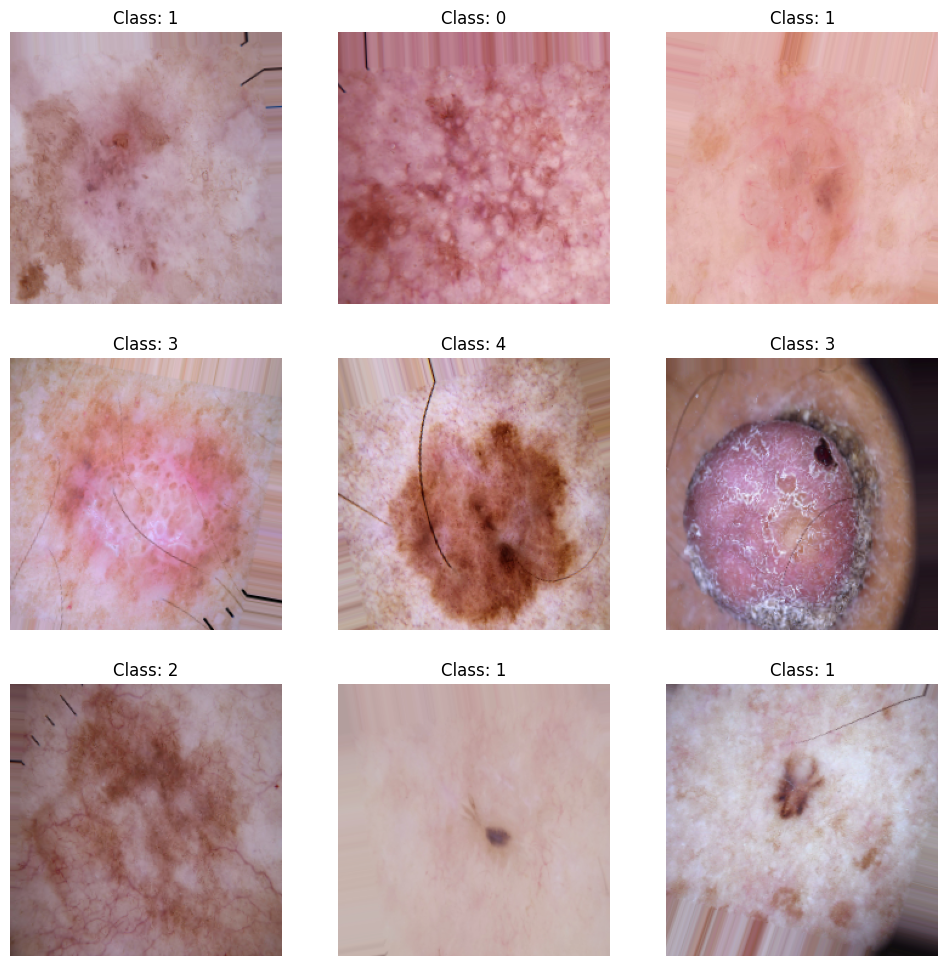

In [13]:
# Extract one batch and visualize
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis('off')
plt.show()

# baseline model


In [15]:
from tensorflow.keras import layers, models, optimizers

def build_baseline_cnn():
    model = models.Sequential([
        # Input
        layers.Input(shape=(224, 224, 3)),

        # Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Flatten
        layers.Flatten(),

        # Fully Connected Head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Output
        layers.Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the model
model = build_baseline_cnn()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Optional but recommended (comment out if not needed)
    ModelCheckpoint(
        filepath='baseline_cnn_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model



I0000 00:00:1768462719.873991      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768462719.878005      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
from IPython.display import FileLink
FileLink("ham10000_baseline_cnn.zip")


/kaggle/working/ham10000_baseline_cnn.zip

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
     initial_epoch=15,
    epochs=20,
    callbacks=callbacks
)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=test_generator.class_indices.keys()
))


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 488ms/step
              precision    recall  f1-score   support

       akiec       0.34      0.61      0.43        49
         bcc       0.45      0.65      0.53        77
         bkl       0.40      0.63      0.49       165
          df       0.24      0.53      0.33        17
         mel       0.26      0.60      0.36       167
          nv       0.98      0.57      0.72      1006
        vasc       0.77      0.77      0.77        22

    accuracy                           0.59      1503
   macro avg       0.49      0.62      0.52      1503
weighted avg       0.77      0.59      0.63      1503



In [ ]:
model.save("ham10000_baseline_cnn.h5")


# using Transfer Learning

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


2026-01-17 02:00:23.399720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768615223.836567      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768615223.974680      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768615225.038676      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768615225.038725      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768615225.038728      55 computation_placer.cc:177] computation placer alr

In [3]:
from sklearn.model_selection import train_test_split

# First split: train + temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['dx'],
    random_state=42
)

# Second split: val + test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['dx'],
    random_state=42
)

print(len(train_df), len(val_df), len(test_df))


7010 1502 1503


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(1.285530900421786), 5: np.float64(0.21338772031292808), 6: np.float64(10.115440115440116)}


In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Phase 1: feature extraction

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1768615320.340493      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768615320.344578      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,416,426 (16.85 MB)

 Trainable params: 364,295 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'efficientnet_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [8]:
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1768615356.681454     136 service.cc:152] XLA service 0x7a2074115c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768615356.681489     136 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768615356.681493     136 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768615359.053056     136 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-17 02:02:47.105261: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:02:47.248269: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:02:47.584031: E external/local_xl

 57/220 ━━━━━━━━━━━━━━━━━━━━ 2:10 798ms/step - accuracy: 0.0845 - loss: 2.9951

2026-01-17 02:03:46.683323: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:03:46.817762: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:03:47.121428: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:03:47.262652: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:03:47.946516: E external/local_xla/xla/stream_

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.1320 - loss: 2.6127

2026-01-17 02:06:38.950604: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:06:39.094576: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:06:39.434229: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:06:39.575335: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 02:06:40.284388: E external/local_xla/xla/stream_


Epoch 1: val_accuracy improved from -inf to 0.34887, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.1322 - loss: 2.6114 - val_accuracy: 0.3489 - val_loss: 1.7370
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.2889 - loss: 1.8873
Epoch 2: val_accuracy improved from 0.34887 to 0.37417, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 540ms/step - accuracy: 0.2890 - loss: 1.8872 - val_accuracy: 0.3742 - val_loss: 1.6101
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.3472 - loss: 1.7174
Epoch 3: val_accuracy improved from 0.37417 to 0.42610, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 544ms/step - accuracy: 0.3473 - loss: 1.7174 - val_accuracy: 0.4261 - val_loss: 1.5099
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.3676 - loss: 1.6447
Epoch 4: val_accuracy improved from 0.42610 to 0.50133, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 545ms/step - accuracy: 0.3676 - loss: 1.6445 - val_accuracy: 0.5013 - val_loss: 1.3476
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4112 - loss: 1.5275
Epoch 5: val_accuracy improved from 0.50133 to 0.53995, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 538ms/step - accuracy: 0.4113 - loss: 1.5272 - val_accuracy: 0.5399 - val_loss: 1.2641
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4653 - loss: 1.3287
Epoch 6: val_accuracy improved from 0.53995 to 0.56525, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 541ms/step - accuracy: 0.4653 - loss: 1.3288 - val_accuracy: 0.5652 - val_loss: 1.1994
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4697 - loss: 1.3524
Epoch 7: val_accuracy did not improve from 0.56525
220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 541ms/step - accuracy: 0.4697 - loss: 1.3525 - val_accuracy: 0.5493 - val_loss: 1.2134
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4699 - loss: 1.3085
Epoch 8: val_accuracy did not improve from 0.56525
220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 535ms/step - accuracy: 0.4699 - loss: 1.3086 - val_accuracy: 0.5433 - val_loss: 1.2030
Epoch 9/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4765 - loss: 1.3040
Epoch 9: val_accuracy did not improve from 0.56525
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 529ms/step - accuracy: 0.4765 - loss: 1.3039 - val_accuracy: 0.5519 - val_loss: 1.1826
Epoch 10/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5052 - loss: 1.2798
Epoch 10: 

220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 535ms/step - accuracy: 0.5052 - loss: 1.2795 - val_accuracy: 0.5806 - val_loss: 1.1229
Epoch 11/30
 55/220 ━━━━━━━━━━━━━━━━━━━━ 1:21 493ms/step - accuracy: 0.5224 - loss: 1.2739
Epoch 11: val_accuracy improved from 0.58056 to 0.58589, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 535ms/step - accuracy: 0.5113 - loss: 1.2509 - val_accuracy: 0.5859 - val_loss: 1.0838
Epoch 12/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5282 - loss: 1.1774
Epoch 12: val_accuracy improved from 0.58589 to 0.59387, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 532ms/step - accuracy: 0.5282 - loss: 1.1774 - val_accuracy: 0.5939 - val_loss: 1.0514
Epoch 13/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5363 - loss: 1.1284
Epoch 13: val_accuracy did not improve from 0.59387
220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 535ms/step - accuracy: 0.5363 - loss: 1.1285 - val_accuracy: 0.5746 - val_loss: 1.1000
Epoch 14/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5421 - loss: 1.0682
Epoch 14: val_accuracy did not improve from 0.59387
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 530ms/step - accuracy: 0.5420 - loss: 1.0686 - val_accuracy: 0.5879 - val_loss: 1.0638
Epoch 15/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5260 - loss: 1.1042
Epoch 15: val_accuracy improved from 0.59387 to 0.60919, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 535ms/step - accuracy: 0.5260 - loss: 1.1042 - val_accuracy: 0.6092 - val_loss: 1.0075
Epoch 16/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5511 - loss: 1.1989
Epoch 16: val_accuracy improved from 0.60919 to 0.61119, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 533ms/step - accuracy: 0.5511 - loss: 1.1984 - val_accuracy: 0.6112 - val_loss: 0.9772
Epoch 17/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5547 - loss: 1.0994
Epoch 17: val_accuracy improved from 0.61119 to 0.61185, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 531ms/step - accuracy: 0.5547 - loss: 1.0994 - val_accuracy: 0.6119 - val_loss: 1.0314
Epoch 18/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5423 - loss: 1.1110
Epoch 18: val_accuracy did not improve from 0.61185
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 526ms/step - accuracy: 0.5423 - loss: 1.1108 - val_accuracy: 0.6052 - val_loss: 1.0190
Epoch 19/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5642 - loss: 1.0305
Epoch 19: val_accuracy improved from 0.61185 to 0.61518, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.5642 - loss: 1.0305 - val_accuracy: 0.6152 - val_loss: 1.0045
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 16.


In [9]:
from IPython.display import FileLink
FileLink('efficientnet_best.h5')


/kaggle/working/efficientnet_best.h5

In [11]:
base_model.trainable = True

# Unfreeze only the LAST 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2_light = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5297 - loss: 1.2134
Epoch 1: val_accuracy improved from 0.61518 to 0.64181, saving model to efficientnet_best.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 169s 665ms/step - accuracy: 0.5297 - loss: 1.2134 - val_accuracy: 0.6418 - val_loss: 0.9224
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5413 - loss: 1.2002
Epoch 2: val_accuracy did not improve from 0.64181
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 545ms/step - accuracy: 0.5413 - loss: 1.2002 - val_accuracy: 0.6298 - val_loss: 0.9680
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.5454 - loss: 1.1766
Epoch 3: val_accuracy did not improve from 0.64181
220/220 ━━━━━━━━━━━━━━━━━━━━ 119s 542ms/step - accuracy: 0.5454 - loss: 1.1766 - val_accuracy: 0.6298 - val_loss: 0.9679
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.5408 - loss: 1.1117
Epoch 4: val_accuracy did not improve from 0.64181
220/220 ━━━━━━━━━━━━━━━━━━━━ 124s 563ms/step - accuracy: 0.5408 - loss: 1.1117 - val_accuracy: 0.6252 - val_loss: 0.9724
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [25]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/efficent-net/tensorflow2/default/1/efficientnet_best.h5")


In [13]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6545 - loss: 1.0298

2026-01-17 03:52:16.560902: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 03:52:16.704196: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 03:52:17.063431: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 03:52:17.204025: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-17 03:52:17.896078: E external/local_xla/xla/stream_

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 741ms/step - accuracy: 0.6541 - loss: 1.0304
Test Loss: 1.0435
Test Accuracy: 0.6454


In [14]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Class names
class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step
              precision    recall  f1-score   support

       akiec       0.33      0.35      0.34        49
         bcc       0.29      0.45      0.35        77
         bkl       0.35      0.41      0.37       165
          df       0.09      0.41      0.15        17
         mel       0.33      0.22      0.27       167
          nv       0.89      0.78      0.83      1006
        vasc       0.31      0.82      0.44        22

    accuracy                           0.65      1503
   macro avg       0.37      0.49      0.39      1503
weighted avg       0.70      0.65      0.67      1503



# Focal Loss 


In [26]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weight * cross_entropy, axis=1)
    return loss


In [27]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='efficientnet_best.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)


In [29]:
history_focal = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,  # KEEP this
    callbacks=callbacks
)


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.5652 - loss: 0.1937
Epoch 1: val_accuracy improved from -inf to 0.55393, saving model to efficientnet_best.weights.h5
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 653ms/step - accuracy: 0.5651 - loss: 0.1937 - val_accuracy: 0.5539 - val_loss: 0.1683
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5511 - loss: 0.1857
Epoch 2: val_accuracy improved from 0.55393 to 0.55925, saving model to efficientnet_best.weights.h5
220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 536ms/step - accuracy: 0.5511 - loss: 0.1857 - val_accuracy: 0.5593 - val_loss: 0.1636
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5513 - loss: 0.1698
Epoch 3: val_accuracy improved from 0.55925 to 0.57457, saving model to efficientnet_best.weights.h5
220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 537ms/step - accuracy: 0.5512 - loss: 0.1698 - val_accuracy: 0.5746 - val_loss: 0.1618
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5419 

In [30]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.6061 - loss: 0.1234
Test accuracy: 0.6087824106216431


In [32]:
# model.save("efficientnet_focal_final.h5")


In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Class names
class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step
              precision    recall  f1-score   support

       akiec       0.51      0.47      0.49        49
         bcc       0.61      0.36      0.46        77
         bkl       0.43      0.61      0.51       165
          df       0.25      0.35      0.29        17
         mel       0.24      0.70      0.36       167
          nv       0.97      0.62      0.76      1006
        vasc       0.57      0.73      0.64        22

    accuracy                           0.61      1503
   macro avg       0.51      0.55      0.50      1503
weighted avg       0.78      0.61      0.65      1503

